Link to tutorial playlist: https://www.youtube.com/watch?v=rdfbcdP75KI&list=PLeo1K3hjS3uu7clOTtwsp94PcHbzqpAdg

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

# Data Exploration

In [5]:
df1 = pd.read_csv("datasets/Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
df1.shape

(13320, 9)

In [7]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [8]:
df1.groupby('area_type').agg({'area_type': 'count'})

,area_type
area_type,
Built-up Area,2418
Carpet Area,87
Plot Area,2025
Super built-up Area,8790


# Data Preparation

## Dropping features that will not be used in model training

In [9]:
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
#df2.describe()
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Dropping missing values

In [11]:
df2.isnull().sum(axis='rows') 

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [12]:
df3 = df2.dropna() 
df3.shape

(13246, 5)

## Removing text from 'size' column and keepin integer values

In [13]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [14]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split()[0]))

C:\Users\lache\AppData\Local\Temp/ipykernel_15608/1698009599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split()[0]))


In [15]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [16]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [17]:
df3[df3['bhk']>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


## Exploring total_sqft

In [18]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [19]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [21]:
mask = df3['total_sqft'].apply(is_float)
df3[~mask]['total_sqft']

30       2100 - 2850
122      3067 - 8156
137      1042 - 1105
165      1145 - 1340
188      1015 - 1540
            ...     
12975     850 - 1060
12990    1804 - 2273
13059    1200 - 1470
13265    1133 - 1384
13299    2830 - 2882
Name: total_sqft, Length: 190, dtype: object

There are certain values which are non-numeric in the 'total_sqft' column. These are size ranges encoded as string values. We can split the lower and upper range using regex and take the midpoint as the value for 'total_sqft' for a given house.

In [20]:
def average_sqft(x):
    try:
        low_range = float(x.split()[0])
        high_range = float(x.split()[2])
        average = np.mean([low_range, high_range])
        return average
    except:
        return None

In [22]:
df3['total_sqft'][~mask] = df3['total_sqft'][~mask].apply(average_sqft)
df3[~mask].head(10)

C:\Users\lache\AppData\Local\Temp/ipykernel_15608/65713947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['total_sqft'][~mask] = df3['total_sqft'][~mask].apply(average_sqft)
C:\Users\lache\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2475,4.0,186.000,4
122,Hebbal,4 BHK,5611.5,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1073.5,2.0,54.005,2
165,Sarjapur,2 BHK,1242.5,2.0,43.490,2
188,KR Puram,2 BHK,1277.5,2.0,56.800,2
410,Kengeri,1 BHK,NaN,1.0,18.500,1
549,Hennur Road,2 BHK,1317.5,2.0,63.770,2
648,Arekere,9 Bedroom,NaN,9.0,265.000,9
661,Yelahanka,2 BHK,1132.5,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,4046,4.0,445.000,4


Let us see if there are any non-float values remaining

In [24]:
mask = df3['total_sqft'].apply(is_float)
df3['total_sqft'][~mask]

Series([], Name: total_sqft, dtype: object)

## Creating new variable - price per sqft

In [26]:
df5 = df3.copy()
df5['total_sqft'] = df5['total_sqft'].astype(float)
df5['price_per_sqft'] = df5['price']*100000 / df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [27]:
df5['price_per_sqft'].describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

## Examining locations variable

In [28]:
len(df5.location.unique())

1304

In [29]:
#df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield                            534
Sarjapur  Road                        392
Electronic City                       302
Kanakpura Road                        266
Thanisandra                           233
                                     ... 
Konappana Agrahara                      1
Kodanda Reddy Layout                    1
Kirloskar layout, Basaveshwarnagar      1
Kengeri Satellite Town Stage II         1
 Anekal                                 1
Name: location, Length: 1304, dtype: int64

In [30]:
len(location_stats[location_stats <= 10])

1063

We see that the 'location' variable has many categories, most of which contain very little instances. We can reduce the number of categories by grouping the locations with less then 10 houses into a new category - 'other'

In [31]:
locations_stats_less_than_10 = location_stats[location_stats <= 10]
locations_stats_less_than_10

location
Ganga Nagar                           10
Nagappa Reddy Layout                  10
BTM 1st Stage                         10
Dodsworth Layout                      10
Kalkere                               10
                                      ..
Konappana Agrahara                     1
Kodanda Reddy Layout                   1
Kirloskar layout, Basaveshwarnagar     1
Kengeri Satellite Town Stage II        1
 Anekal                                1
Name: location, Length: 1063, dtype: int64

In [32]:
df5.location = df5.location.apply(lambda x: 'other' if x in locations_stats_less_than_10 else x)
len(df5.location.unique())

242

In [33]:
df5.location.head(15)

0     Electronic City Phase II
1             Chikka Tirupathi
2                  Uttarahalli
3           Lingadheeranahalli
4                     Kothanur
5                   Whitefield
6             Old Airport Road
7                 Rajaji Nagar
8                 Marathahalli
9                        other
10                  Whitefield
11                  Whitefield
12          7th Phase JP Nagar
13                   Gottigere
14                    Sarjapur
Name: location, dtype: object

## Outlier removal

Based on business logic we can remove the houses with less than 300 sqft per bedroom.

In [34]:
df5[(df5.total_sqft/df5.bhk)<300].describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,744.000000,744.000000,744.000000,744.000000,7.440000e+02
mean,971.224462,4.840054,130.495054,5.342742,3.491305e+04
std,452.337485,2.717266,81.466194,2.620347,4.486481e+05
min,1.000000,1.000000,8.000000,1.000000,2.045455e+03
25%,600.000000,3.000000,77.750000,4.000000,9.430544e+03
50%,942.500000,4.000000,110.000000,5.000000,1.250000e+04
75%,1200.000000,6.000000,165.000000,6.000000,1.625000e+04
max,8000.000000,40.000000,675.000000,43.000000,1.200000e+07


In [35]:
df6 = df5[~((df5.total_sqft/df5.bhk)<300)]
df6.shape

(12502, 7)

We can also explore the variability of price per square foot variable.

In [36]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

<AxesSubplot:ylabel='Frequency'>

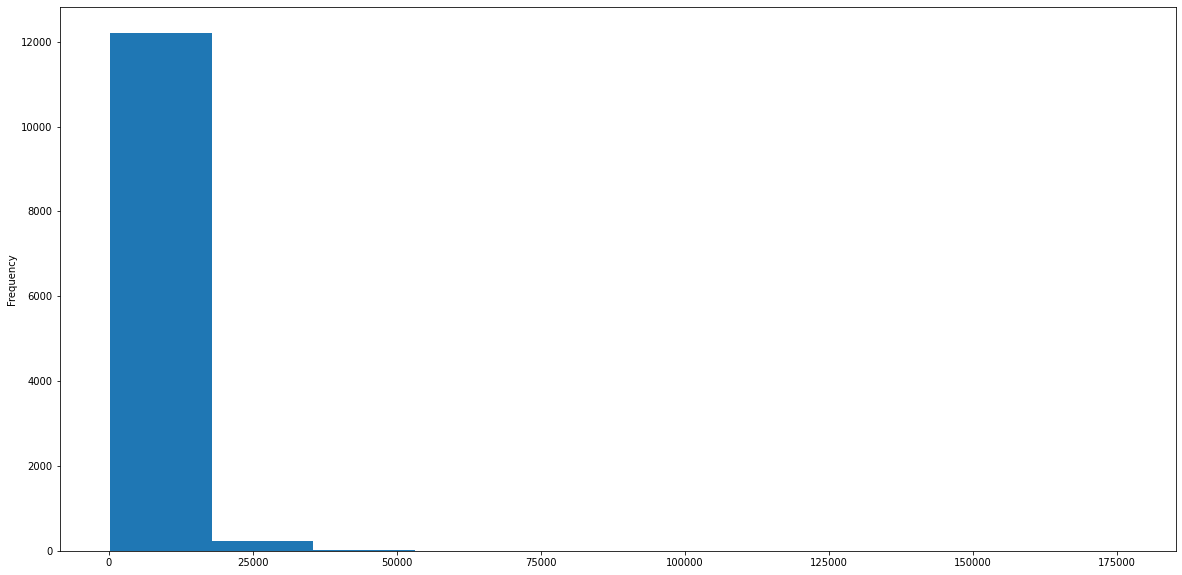

In [37]:
df6['price_per_sqft'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

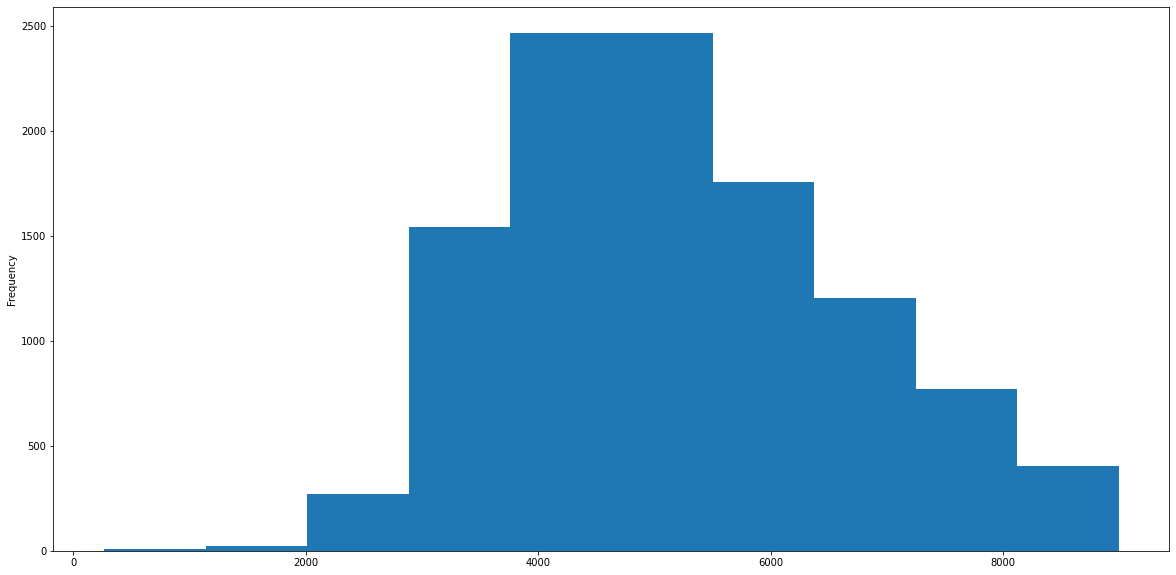

In [38]:
#df6.price_per_sqft.plot.hist()
df6[(df6['price_per_sqft']<9000)]['price_per_sqft'].plot.hist()

We can remove the values that are farther than three standard deviations away from the mean in either direction

In [39]:
# This function removes apartments which have a price_per_sqft is more than 3 standard deviation above or below the mean per location

def remove_ppsqft_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        mean = np.mean(subdf.price_per_sqft)
        standard_div = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>=(mean-standard_div*3)) & (subdf.price_per_sqft<=(mean+standard_div*3))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [40]:
df7 = remove_ppsqft_outliers(df6)
df7.shape

(12265, 7)

We can also remove apartments whose price_per_sqft is larger than the mean price_per_sqft of apartments with 1 less room in the same location. For example, 3-bedroom apartments which are cheaper than the average 2-bedroom apartment in the same location.

In [41]:
# This function removes apartments whose price_per_sqft is larger than the mean price_per_sqft of apartments with 1 less room in the same location

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [42]:
df8 = remove_bhk_outliers(df7)
df8.shape

(8640, 7)

Text(0, 0.5, 'Count')

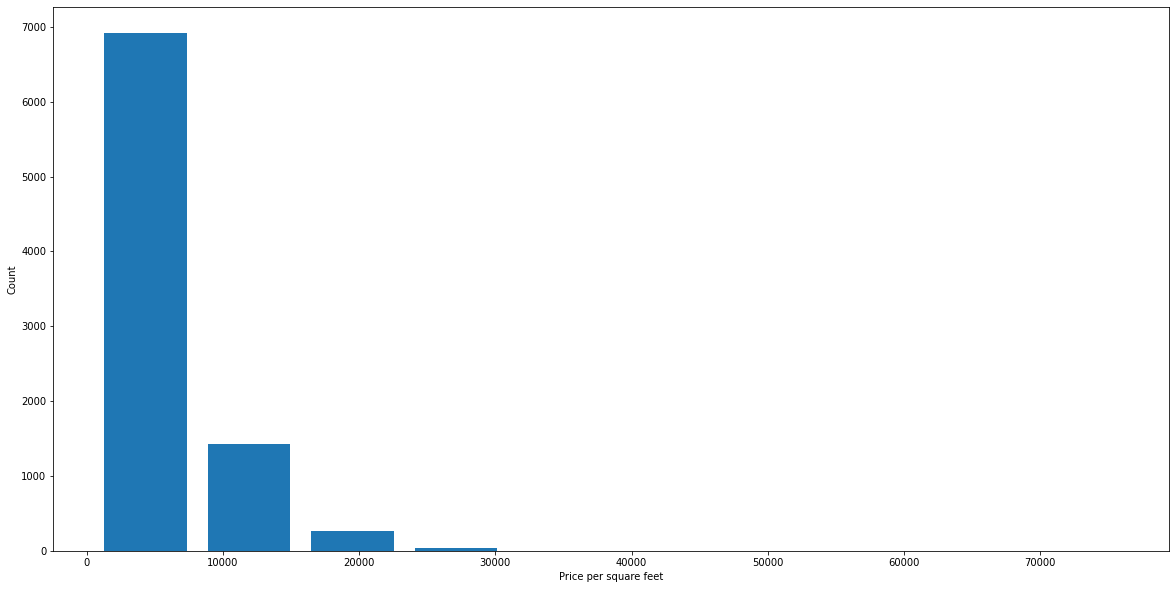

In [43]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel('Price per square feet')
plt.ylabel('Count')

In [44]:
df8.bath.unique()

array([ 2.,  3.,  4.,  5.,  7.,  1.,  8.,  6.,  9., 10., 12., 14., 16.,
       13.])

In [46]:
df8[df8['bath']>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
6485,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
9960,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
10432,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
11251,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
11617,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


<AxesSubplot:ylabel='Frequency'>

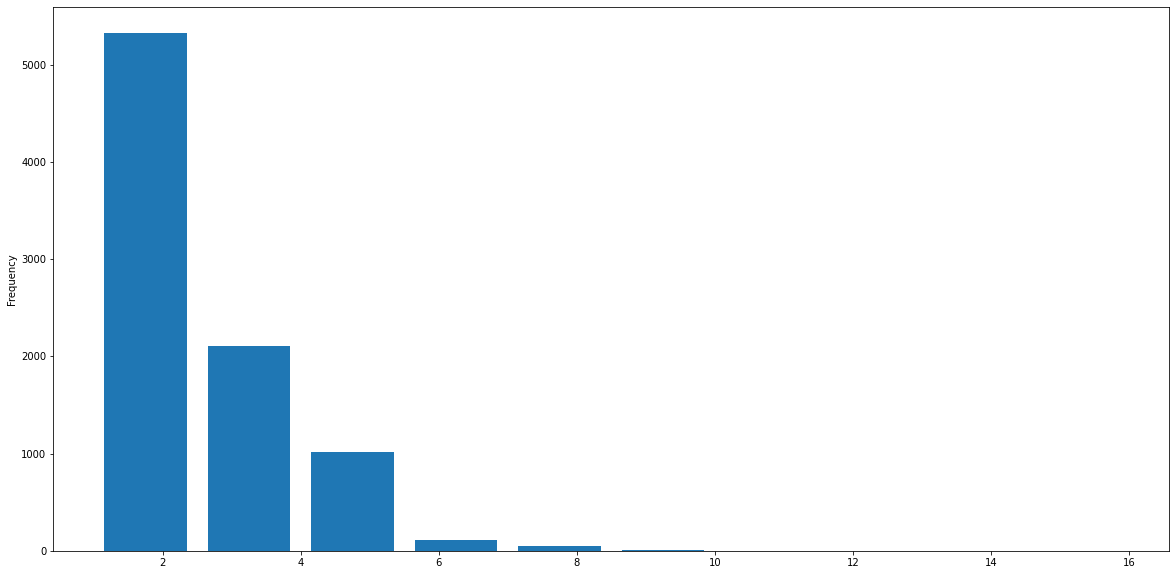

In [47]:
df8['bath'].plot.hist(rwidth=0.8)

We can also remove the homes which have 2 more bathrooms than bedrooms as this is quite untypical and might even allude to erroneous data. 

In [48]:
# Remove apartments which have № of bathrooms greater the № of bedrooms + 2

mask = df8['bath']<(df8['bhk']+2) # this should be <= as it would be normal to have the same number of baths as bedrooms but I am keeping it this way to be the same as the tutorial

df9 = df8[mask]
df9.shape

(8523, 7)

In [49]:
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1,Devarachikkanahalli,2 BHK,1250.0,2.0,40.0,2,3200.000000
2,Devarachikkanahalli,2 Bedroom,1200.0,2.0,83.0,2,6916.666667
3,Devarachikkanahalli,2 BHK,1170.0,2.0,40.0,2,3418.803419
4,Devarachikkanahalli,3 BHK,1425.0,2.0,65.0,3,4561.403509
5,Devarachikkanahalli,2 BHK,947.0,2.0,43.0,2,4540.654699


In [50]:
df10 = df9.drop(['size', 'price_per_sqft'], axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,43.0,2


## Creating dummy variables for location

In [51]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df11 = pd.concat([df10, dummies.drop('other', axis='columns')], axis='columns') # other will be our reference category
df11.head(3)

,location,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,Devarachikkanahalli,1250.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Devarachikkanahalli,1200.0,2.0,83.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Devarachikkanahalli,1170.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df12 = df11.drop('location', axis='columns')
df12.head()

,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,83.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,65.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,43.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df12.shape

(8523, 245)

# Modelling

In [55]:
X = df12.drop('price', axis='columns')
X.head()

,total_sqft,bath,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
y = df12.price
y.head()

1    40.0
2    83.0
3    40.0
4    65.0
5    43.0
Name: price, dtype: float64

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [58]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression() 
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.6042240591620953

In [62]:
#lr_clf.intercept_ # gets the intercept
# lr_clf.coef_ # gets the coefficients for each feature

In [63]:
# getting the named coefficients with dict comprehension
features = list(X.columns)
coefficients = list(lr_clf.coef_)
named_coefficients = {features[i]: coefficients[i] for i in range(len(features))}
named_coefficients

{'total_sqft': 0.10107514836651144,
 'bath': 1.7056553375316952,
 'bhk': 3.7960624670375296,
 ' Devarachikkanahalli': -77.04632490809354,
 '1st Block Jayanagar': 53.940554911452466,
 '1st Phase JP Nagar': -14.511658470474714,
 '2nd Phase Judicial Layout': -84.50085524677868,
 '2nd Stage Nagarbhavi': 66.70055017517993,
 '5th Block Hbr Layout': -117.30428482336518,
 '5th Phase JP Nagar': -81.22791624407277,
 '6th Phase JP Nagar': -57.920287056985856,
 '7th Phase JP Nagar': -59.769246411998985,
 '8th Phase JP Nagar': -61.54491189678565,
 '9th Phase JP Nagar': -79.16358515831124,
 'AECS Layout': -70.75061725297374,
 'Abbigere': -86.18993157497559,
 'Akshaya Nagar': -78.95108674125731,
 'Ambalipura': -66.02085391957704,
 'Ambedkar Nagar': -68.35105118134422,
 'Amruthahalli': -61.23470754130557,
 'Anandapura': -70.07547207515209,
 'Ananth Nagar': -75.10183497510639,
 'Anekal': -74.91732778521856,
 'Anjanapura': -62.34619804726222,
 'Ardendale': -98.0957404543627,
 'Arekere': -76.470090603275

In [199]:
# getting the named coefficients with zip()

features = list(X.columns)
coefficients = list(lr_clf.coef_)
named_coefficients = dict(zip(features, coefficients))
named_coefficients

{'total_sqft': 0.07941537392443081,
 'bath': 5.079024944512794,
 'bhk': -1.7728777642470845,
 '1st Block Jayanagar': 120.1026836079061,
 '1st Phase JP Nagar': 1.609751311664752,
 '2nd Phase Judicial Layout': -53.16321913918685,
 '2nd Stage Nagarbhavi': 100.74470901990432,
 '5th Block Hbr Layout': -70.98149330012978,
 '5th Phase JP Nagar': -39.21595424647559,
 '6th Phase JP Nagar': -19.01728514037446,
 '7th Phase JP Nagar': -18.657090253870646,
 '8th Phase JP Nagar': -47.859708585629136,
 '9th Phase JP Nagar': -45.80726840808923,
 'AECS Layout': -36.31031834844076,
 'Abbigere': -53.71884390830042,
 'Akshaya Nagar': -43.201493277550384,
 'Ambalipura': -28.33344558394132,
 'Ambedkar Nagar': -30.9802726708115,
 'Amruthahalli': -34.134998327941574,
 'Anandapura': -43.55421642743196,
 'Ananth Nagar': -46.85574954664794,
 'Anekal': -35.544384309151624,
 'Anjanapura': -51.34133220938104,
 'Ardendale': -44.11613217244372,
 'Arekere': -33.91073912965313,
 'Attibele': -35.09945824849143,
 'BEML L

In [64]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.73057637, 0.65682335, 0.57414432, 0.66932802, 0.77452699])

In [72]:
# Finding the best model and parameters with GridSearchCV

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor


def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.01, 0.1, 0.5, 1, 2],
                'normalize' : [True, False],
                'selection': ['random', 'cyclic']
            }
            },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.01, 0.1, 0.5, 1, 2],
                'normalize' : [True, False],
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False, verbose=3)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] normalize=True ..................................................
[CV] ...................... normalize=True, score=0.731, total=   0.2s
[CV] normalize=True ..................................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] ...................... normalize=True, score=0.657, total=   0.2s
[CV] normalize=True ..................................................

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s



[CV] ...................... normalize=True, score=0.574, total=   0.2s
[CV] normalize=True ..................................................
[CV] ...................... normalize=True, score=0.669, total=   0.2s
[CV] normalize=True ..................................................
[CV] ...................... normalize=True, score=0.775, total=   0.2s
[CV] normalize=False .................................................
[CV] ..................... normalize=False, score=0.731, total=   0.2s
[CV] normalize=False .................................................
[CV] ..................... normalize=False, score=0.657, total=   0.2s
[CV] normalize=False .................................................
[CV] ..................... normalize=False, score=0.574, total=   0.2s
[CV] normalize=False .................................................
[CV] ..................... normalize=False, score=0.669, total=   0.2s
[CV] normalize=False .................................................
[CV] 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] alpha=0.01, normalize=True, selection=random ....................
[CV]  alpha=0.01, normalize=True, selection=random, score=0.714, total=   0.4s
[CV] alpha=0.01, normalize=True, selection=random ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  alpha=0.01, normalize=True, selection=random, score=0.637, total=   0.3s
[CV] alpha=0.01, normalize=True, selection=random ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  alpha=0.01, normalize=True, selection=random, score=0.559, total=   0.2s
[CV] alpha=0.01, normalize=True, selection=random ....................
[CV]  alpha=0.01, normalize=True, selection=random, score=0.646, total=   0.4s
[CV] alpha=0.01, normalize=True, selection=random ....................
[CV]  alpha=0.01, normalize=True, selection=random, score=0.763, total=   0.3s
[CV] alpha=0.01, normalize=True, selection=cyclic ....................
[CV]  alpha=0.01, normalize=True, selection=cyclic, score=0.714, total=   0.2s
[CV] alpha=0.01, normalize=True, selection=cyclic ....................
[CV]  alpha=0.01, normalize=True, selection=cyclic, score=0.637, total=   0.2s
[CV] alpha=0.01, normalize=True, selection=cyclic ....................
[CV]  alpha=0.01, normalize=True, selection=cyclic, score=0.559, total=   0.1s
[CV] alpha=0.01, normalize=True, selection=cyclic ....................
[CV]  alpha=0.01, normalize=True, selection=cyclic, score=0.646, total=   0.2s
[CV] alpha=0.01, norm

[CV]  alpha=0.5, normalize=False, selection=cyclic, score=0.604, total=   0.2s
[CV] alpha=0.5, normalize=False, selection=cyclic ....................
[CV]  alpha=0.5, normalize=False, selection=cyclic, score=0.716, total=   0.2s
[CV] alpha=1, normalize=True, selection=random .......................
[CV]  alpha=1, normalize=True, selection=random, score=0.261, total=   0.1s
[CV] alpha=1, normalize=True, selection=random .......................
[CV]  alpha=1, normalize=True, selection=random, score=0.196, total=   0.1s
[CV] alpha=1, normalize=True, selection=random .......................
[CV]  alpha=1, normalize=True, selection=random, score=0.233, total=   0.1s
[CV] alpha=1, normalize=True, selection=random .......................
[CV]  alpha=1, normalize=True, selection=random, score=0.190, total=   0.1s
[CV] alpha=1, normalize=True, selection=random .......................
[CV]  alpha=1, normalize=True, selection=random, score=0.204, total=   0.1s
[CV] alpha=1, normalize=True, select

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=0.01, normalize=True ......................................
[CV] .......... alpha=0.01, normalize=True, score=0.731, total=   0.1s
[CV] alpha=0.01, normalize=True ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......... alpha=0.01, normalize=True, score=0.654, total=   0.1s
[CV] alpha=0.01, normalize=True ......................................
[CV] .......... alpha=0.01, normalize=True, score=0.582, total=   0.1s
[CV] alpha=0.01, normalize=True ......................................
[CV] .......... alpha=0.01, normalize=True, score=0.667, total=   0.1s
[CV] alpha=0.01, normalize=True ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .......... alpha=0.01, normalize=True, score=0.774, total=   0.1s
[CV] alpha=0.01, normalize=False .....................................
[CV] ......... alpha=0.01, normalize=False, score=0.731, total=   0.1s
[CV] alpha=0.01, normalize=False .....................................
[CV] ......... alpha=0.01, normalize=False, score=0.657, total=   0.1s
[CV] alpha=0.01, normalize=False .....................................
[CV] ......... alpha=0.01, normalize=False, score=0.574, total=   0.1s
[CV] alpha=0.01, normalize=False .....................................
[CV] ......... alpha=0.01, normalize=False, score=0.669, total=   0.1s
[CV] alpha=0.01, normalize=False .....................................
[CV] ......... alpha=0.01, normalize=False, score=0.775, total=   0.1s
[CV] alpha=0.1, normalize=True .......................................
[CV] ........... alpha=0.1, normalize=True, score=0.721, total=   0.1s
[CV] alpha=0.1, normalize=True .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ criterion=mse, splitter=best, score=0.398, total=   0.6s
[CV] criterion=mse, splitter=best ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ........ criterion=mse, splitter=best, score=0.632, total=   0.5s
[CV] criterion=mse, splitter=best ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ........ criterion=mse, splitter=best, score=0.599, total=   0.6s
[CV] criterion=mse, splitter=best ....................................
[CV] ........ criterion=mse, splitter=best, score=0.525, total=   0.5s
[CV] criterion=mse, splitter=best ....................................
[CV] ........ criterion=mse, splitter=best, score=0.503, total=   0.4s
[CV] criterion=mse, splitter=random ..................................
[CV] ...... criterion=mse, splitter=random, score=0.474, total=   0.5s
[CV] criterion=mse, splitter=random ..................................
[CV] ...... criterion=mse, splitter=random, score=0.662, total=   0.6s
[CV] criterion=mse, splitter=random ..................................
[CV] ...... criterion=mse, splitter=random, score=0.484, total=   0.4s
[CV] criterion=mse, splitter=random ..................................
[CV] ...... criterion=mse, splitter=random, score=0.500, total=   0.4s
[CV] criterion=mse, splitter=random ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.1s finished


,model,best_score,best_params
0,linear_regression,0.681080,{'normalize': False}
1,lasso,0.680705,"{'alpha': 0.01, 'normalize': False, 'selection..."
2,ridge,0.682629,"{'alpha': 1, 'normalize': False}"
3,decision_tree,0.545902,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


The models have very similar R2 values. The best performing model is the ridge regressor with an alpha of 1 and no normalization. Let us fit this model and see how it predicts.

In [78]:
ridge_model = Ridge(alpha=1, normalize=False) 
ridge_model.fit(X_train, y_train)

Ridge(alpha=1)

In [79]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return ridge_model.predict([x])[0]

In [80]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

96.34597911411242

In [81]:
predict_price('1st Phase JP Nagar',1000, 3, 1)

94.66522214112346

In [82]:
predict_price('Indira Nagar',1000, 2, 2)

185.81496718069326

In [83]:
predict_price('Indira Nagar',1000, 3, 3)

191.6887627597806

## Exporting model

In [84]:
import pickle
with open('banglore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(ridge_model, f)

In [86]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))